In [2]:
import numpy as np 
import xarray as xr 
import scipy 
import matplotlib.pyplot as plt  # Plotting library
import cartopy, cartopy.crs as ccrs  # Plot maps
import random 
import satcmaps as cmaps
import image_retrieval as img
import goesRequest2 as goes 
from recenterIR import recenter_ir

In [3]:
def calculate_degrees(dataset): # Adapted from https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = dataset['x']  # E/W scanning angle in radians
    y_coordinate_1d = dataset['y']  # N/S elevation angle in radians
    projection_info = dataset['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    x_coordinate_1d.close()
    y_coordinate_1d.close()
    projection_info.close()
    dataset.close()
    
    return abi_lat, abi_lon


In [4]:
def reproject(dataset, lats, lons, pos):   
    size = 3.6
    IR = dataset['CMI'].data - 273.15
                        
    # Extents and interpolation for IR
    minimglat = pos[0] - size
    maximglat = pos[0] + size
    minimglon = pos[1] - size
    maximglon = pos[1] + size
    res = 0.0179985     # degrees resolution at nadir
    grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
    
    lats = lats.flatten()
    lons = lons.flatten()
    IR = IR.flatten()
    
    # Fix shape issue for boolean conditions
    floater_IR = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                    np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

    gridded_data = scipy.interpolate.griddata((lats[floater_IR], lons[floater_IR]), IR[floater_IR], (grid[0], grid[1]), method='linear')
    
    dataset.close()

    return grid[1], grid[0], gridded_data

In [5]:
def rePoPolar(dataset, lats, lons, center = None):
    if center is None:
        clat = np.nanmean(lats)
        clon = np.nanmean(lons)
    else:
        clat, clon = center

    R = 6371.0
    cphi = np.cos(np.radians(clat))
    x = R * np.radians(lons - clon) * cphi
    y = R * np.radians(lats - clat)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(0, 500, 500)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    polar = polar.sel(r = slice(0, 500))
    polar = polar.interp(r = np.arange(0, 500, 1))

    return x, y, polar['data']


In [1]:
def runv2(polar):
    # data = np.array([np.nanmean(polar.values, axis = 1), np.nanstd(polar.values, axis = 1)])
    data = polar.sel(r = slice(30, 70)).mean('r').values

    return data

In [6]:
def compute(ir_azi, ir_std):
    from scipy.ndimage import gaussian_filter1d

    ir_std = gaussian_filter1d(ir_std, sigma = 6)
    radii = np.arange(0, 500, 1)#polar.r.values

    diff = (np.diff(ir_std) / np.diff(radii))
    diff2_std = np.diff(diff) / np.diff(radii[1:])
    diff2 = np.diff(ir_azi) / np.diff(radii)
    diff2 = gaussian_filter1d(diff2, sigma = 2)

    min_ir_rad, min_ir_radARG = radii[np.nanargmin(ir_azi)], np.nanargmin(ir_azi)
    min_ir_temp = np.nanmin(ir_azi)
    try:
        eyerad, eyeradARG = radii[np.nanargmin(diff2[:np.nanargmin(ir_azi)])], np.nanargmin(diff2[:np.nanargmin(ir_azi)]) 
    except:
        eyerad, eyeradARG = 0, 0
    eyetemp = np.nanmax(ir_azi[radii < min_ir_rad])
    try:
        icdoedge, icdoedgeARG = (eyerad + min_ir_rad) / 2, int((eyeradARG + min_ir_radARG) / 2)
    except:
        icdoedge, icdoedgeARG = eyerad, eyeradARG
    tempArray = np.arange(0, 499, dtype = 'float32')

    temp = int(min_ir_radARG)
    thresh = min_ir_temp + 10
    zeroPoint = temp + np.where((ir_azi[temp:] > thresh))[0][0]
    ocdoedge, ocdoedgeARG = radii[zeroPoint], zeroPoint

    cdostd = np.nanmean(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    mincdostd = np.nanmin(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    maxcdostd = np.nanmax(ir_std[icdoedgeARG:int(ocdoedgeARG)])

    cdorad = ocdoedge - eyerad
    plt.show()

    return np.array([ocdoedge, eyerad, min_ir_temp, min_ir_rad, eyetemp, cdostd, mincdostd, maxcdostd])

In [6]:
def getStormParams(dataset, satt, year, month, day, time, loc, locType = 'first'):
    t = f'{year}-{str(month).zfill(2)}-{str(day).zfill(2)}_{time}'
    
    allLats, allLons = calculate_degrees(dataset)
    lons, lats, data = reproject(dataset, allLats, allLons, loc)
    dataset.close()
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    if locType.lower() == 'best':
        tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(data, xkm, ykm, 10, lons, lats)
        if (tc_center_lat, tc_center_lon) != (np.nan, np.nan):
            loc = (tc_center_lat, tc_center_lon)
            print('New Coordinates: ', tc_center_lat, tc_center_lon)

            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
        else:
            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)

    processedData = runv2(polar)

    return processedData

In [10]:
import numpy as np
import xarray as xr 
import s3fs
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import datetime
import warnings 
warnings.simplefilter(action='ignore', category=UserWarning)

# Function that retrieves GOES-R data based on satellite and requested band (single band format)
# Resulting file is called "goesfile.nc"
# Data is returned at full resolution, regardless of band
def getData(satellite, year, month, day, time, band, loc, meso = False, num = 1):
    date = datetime.date(year, month, day)
    date = date.timetuple().tm_yday
    hour = time[0:2] 

    fs = s3fs.S3FileSystem(anon=True)
    fs.ls('s3://noaa-goes16/')
    
    if meso == True:
        name = f'CMIPM'
    else:
        name = 'CMIPF'

    files = fs.ls(f'noaa-goes{satellite}/ABI-L2-{name}/{str(year)}/{str(date)}/{str(hour).zfill(2)}/')
    files = np.array(files)

    l = []
    for x in range(len(files)):
        if ((f'M6C{band.zfill(2)}' in files[x]) or (f'M4C{band.zfill(2)}' in files[x]) or (f'M3C{band.zfill(2)}' in files[x])):
            if meso == True and (f'CMIPM{num}' in files[x]):
                l.append(files[x])
            elif 'CMIPF' in files[x]:
                l.append(files[x])
            
    for x in range(len(l)):
        if time in l[x]:
            file = l[x]

    try:
        fs.get(file, r"C:\Users\deela\Downloads\goesLoopfile3.nc")
        with xr.open_dataset(r"C:\Users\deela\Downloads\goesLoopfile3.nc") as data:
            params = getStormParams(data, satellite, year, month, day, time, loc, locType = 'best')

            data.close()
    except Exception as e:
        print(e)
        params = np.array([np.nan for x in range(0, 500)])#, [np.nan for x in range(0, 500)]])
    return params

In [16]:
import numpy as np

satt = '19'
band = '13'

year = 2025
month = 10
day = 28
times = [f"{h:02d}{m:02d}" for h in range(12, 15) for m in range(0, 60, 1)]# + [f"{h:02d}{m:02d}" for h in range(0, 24) for m in range(0, 60, 10)] 
bPos = np.array([[0, 17.5, -78.1], [3, 17.9, -77.9]]).T
bTime = bPos[0]
bLat = bPos[1]
bLon = bPos[2]

bTarget = np.arange(0, 3, 1 / 60)
bLat = np.interp(bTarget, bTime, bLat)
bLon = np.interp(bTarget, bTime, bLon)

In [17]:
print(bTarget.shape, bLat.shape, bLon.shape, len(times))
# print(bTarget)
print(times)

(180,) (180,) (180,) 180
['1200', '1201', '1202', '1203', '1204', '1205', '1206', '1207', '1208', '1209', '1210', '1211', '1212', '1213', '1214', '1215', '1216', '1217', '1218', '1219', '1220', '1221', '1222', '1223', '1224', '1225', '1226', '1227', '1228', '1229', '1230', '1231', '1232', '1233', '1234', '1235', '1236', '1237', '1238', '1239', '1240', '1241', '1242', '1243', '1244', '1245', '1246', '1247', '1248', '1249', '1250', '1251', '1252', '1253', '1254', '1255', '1256', '1257', '1258', '1259', '1300', '1301', '1302', '1303', '1304', '1305', '1306', '1307', '1308', '1309', '1310', '1311', '1312', '1313', '1314', '1315', '1316', '1317', '1318', '1319', '1320', '1321', '1322', '1323', '1324', '1325', '1326', '1327', '1328', '1329', '1330', '1331', '1332', '1333', '1334', '1335', '1336', '1337', '1338', '1339', '1340', '1341', '1342', '1343', '1344', '1345', '1346', '1347', '1348', '1349', '1350', '1351', '1352', '1353', '1354', '1355', '1356', '1357', '1358', '1359', '1400', '1401'

In [18]:
IRData = []
change = False
for x in range(0, len(bTarget)):
    time = times[x]
    if bTarget[x] >= 24 and change == False:
        change = True 
        day = day + 1
    loc = (bLat[x], bLon[x])
    print(x, ': ', year, month, day, time, float(bLat[x]), float(bLon[x]))
    data = getData(satt, year, month, day, time, band, loc, meso = True)
    print('Eye Temperature: ', np.nanmax(data[0]), 'C\nMin Temperature: ', np.nanmin(data[0]), '\n')
    IRData.append(data)
print(IRData)

0 :  2025 10 28 1200 17.5 -78.1
New Coordinates:  17.499699999999827 -78.1182984999991
Eye Temperature:  -78.2485660546162 C
Min Temperature:  -78.2485660546162 

1 :  2025 10 28 1201 17.502222222222223 -78.09888888888888
New Coordinates:  17.50192222222205 -78.11718738888798
Eye Temperature:  -78.29898097060557 C
Min Temperature:  -78.29898097060557 

2 :  2025 10 28 1202 17.504444444444445 -78.09777777777778
New Coordinates:  17.50414444444427 -78.11607627777688
Eye Temperature:  -78.27772101702216 C
Min Temperature:  -78.27772101702216 

3 :  2025 10 28 1203 17.506666666666668 -78.09666666666666
New Coordinates:  17.506366666666494 -78.11496516666577
Eye Temperature:  -78.40291503149682 C
Min Temperature:  -78.40291503149682 

4 :  2025 10 28 1204 17.50888888888889 -78.09555555555555
New Coordinates:  17.508588888888717 -78.11385405555465
Eye Temperature:  -78.46762628606206 C
Min Temperature:  -78.46762628606206 

5 :  2025 10 28 1205 17.511111111111113 -78.09444444444443
New Coord

In [16]:
# band = '09'
# WVData = []
# for x in range(0, len(bTarget)):
#     time = times[x]
#     loc = (bLat[x], bLon[x])
#     print(year, month, day, time, loc)
#     data = getData(satt, year, month, day, time, band, loc)
#     print(x, np.nanmax(data))
#     WVData.append(data)
# print(WVData)

In [25]:
# print(np.array(IRData).shape, np.array(WVData).shape)
# allData = np.array(IRData) - np.array(WVData)
# print(allData.shape)
allData = np.array(IRData)# - np.array(WVData)
print(allData.shape)

(180, 200)


In [29]:
params = []
for x in range(len(allData)):
    try:
        l = compute(allData[x, 0], allData[x, 1])
    except:
        l = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    params.append(l)
params = np.array(params)

cdoRad = params[:, 0]
eyeRad = params[:, 1]
minTmp = params[:, 2]
minRad = params[:, 3]
eyeTmp = params[:, 4]
cdoStd = params[:, 5]
minStd = params[:, 6]
maxStd = params[:, 7]

NameError: name 'cdoRad' is not defined

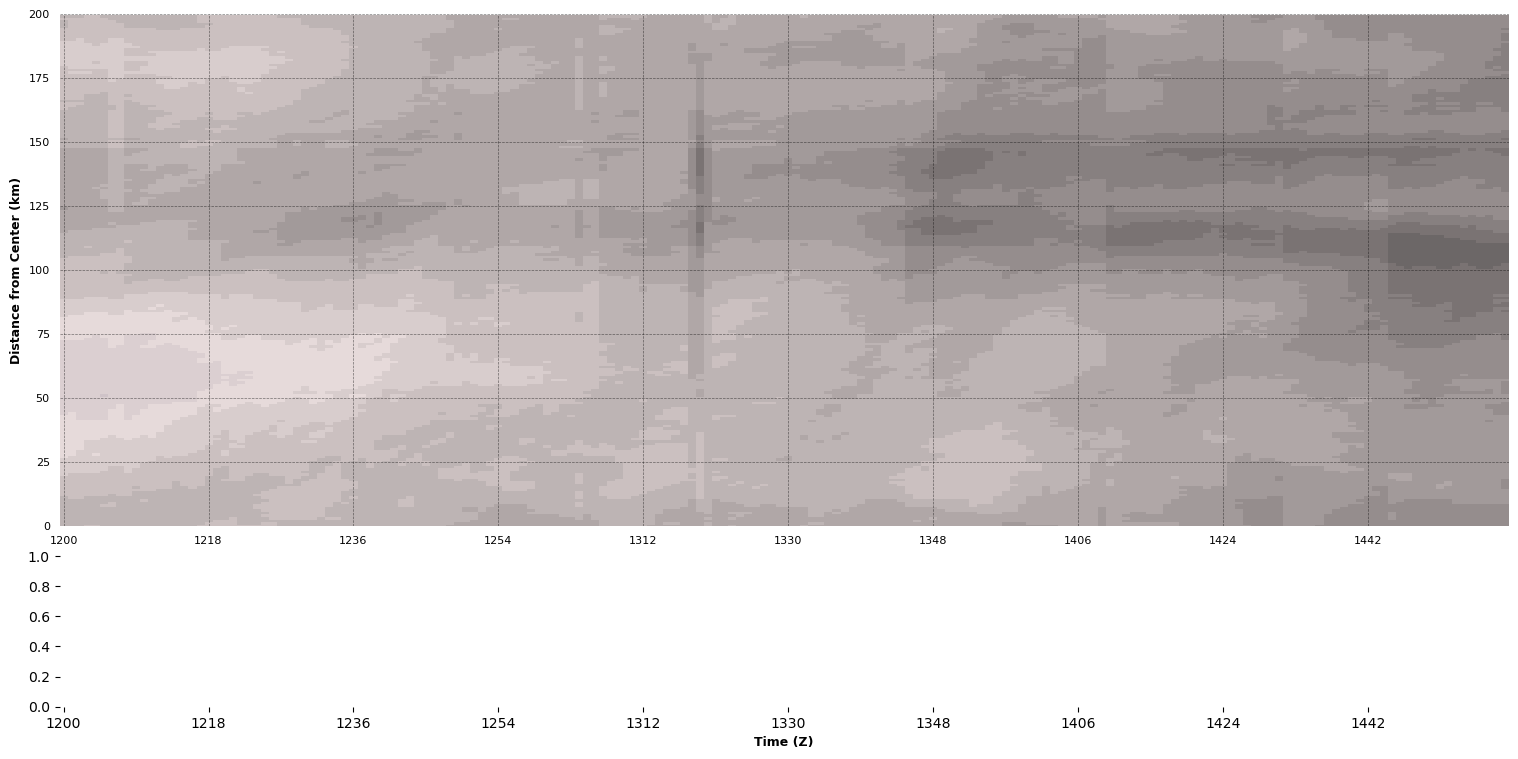

In [27]:
data = allData.T

yLabels = [times[x] for x in range(len(times)) if x % 18 == 0]
xCoord = np.arange(0, len(data[0]))
yCoord = np.arange(0, len(data))

import satcmaps as cmaps
cmap = 'irg'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(4, 1, wspace = 0, hspace = 0.2, right=0.93)

ax = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[3, 0], sharex = ax)

ax.set_frame_on(False)
ax2.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_ylabel('Distance from Center (km)', weight = 'bold', size = 9)
ax2.set_xlabel('Time (Z)', weight = 'bold', size = 9)
ax.set_xticks(np.arange(0, len(times), 18))
ax.set_xticklabels(yLabels)
ax.set_ylim(0, 200)

c = ax.pcolormesh(xCoord, yCoord, data, cmap = cmap, vmax = vmax, vmin = vmin)
# c = plt.contourf(np.arange(0, len(allData[0])), np.arange(0, len(allData)), allData, cmap = cmap, levels = np.arange(vmin, vmax + 1, 1))
print(len(data), len(data[0]), len(cdoRad))
ax.plot(xCoord, cdoRad, color = 'blue', linewidth = 2, label = 'Outer CDO Edge')
ax.plot(xCoord, eyeRad, color = 'black', linewidth = 2, label = 'Eye Radius')
ax.plot(xCoord, minRad, color = 'red', linewidth = 2, label = 'Min. IR Radius')

ax.legend(loc = 'upper left')

ax2.set_xticks(np.arange(0, len(times), 18))
ax2.set_xticklabels(yLabels)
ax2.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax2.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax2.plot(xCoord, 1 / cdoStd, color = 'black', linewidth = 2)
ax2.fill_between(xCoord, 1 / minStd, 1 / maxStd, color='#81c081', label = 'Min to Max')
ax2.plot(xCoord, 1 / minStd, color = '#98ab98', zorder = 50, linewidth = 1.5)
ax2.plot(xCoord, 1 / maxStd, color = '#98ab98', zorder = 50, linewidth = 1.5)
# ax2.plot(np.arange(0, len(data[0])), eyeTmp, color = 'black', linewidth = 2, label = 'Eye Temp')
# ax2.plot(np.arange(0, len(data[0])), minTmp, color = 'red', linewidth = 2, label = 'Min. IR Temp')
ax2.set_ylabel('1 / CDO S.D.', weight = 'bold', size = 9)
ax2.set_ylim(0, 2.45)
ax2.legend(loc = 'upper left')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Larry', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'September 5-6th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar_ax = fig.add_axes([0.94, 0.31, 0.0075, 0.57])
cbar = plt.colorbar(c, orientation = 'vertical', cax = cbar_ax, label = 'Brightness Temperature (C)')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\hovmollerIRFull.png", dpi = 400, bbox_inches = 'tight')
plt.show()

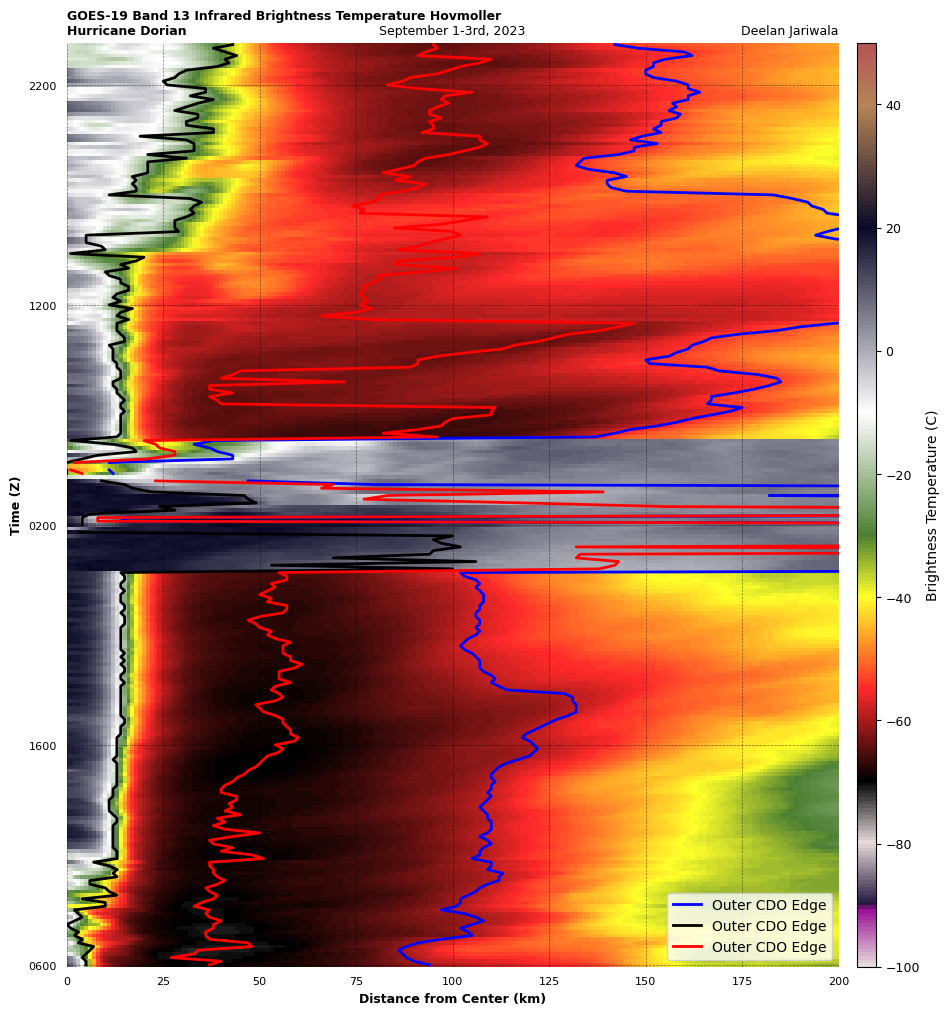

In [27]:
yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

data = allData[:, 0]

import satcmaps as cmaps
cmap = 'irg'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 200)

c = plt.pcolormesh(np.arange(0, len(data[0])), np.arange(0, len(data)), data, cmap = cmap, vmax = vmax, vmin = vmin)
# c = plt.contourf(np.arange(0, len(allData[0])), np.arange(0, len(allData)), allData, cmap = cmap, levels = np.arange(vmin, vmax + 1, 1))

plt.plot(cdoRad, np.arange(0, len(data)), color = 'blue', linewidth = 2, label = 'Outer CDO Edge')
plt.plot(eyeRad, np.arange(0, len(data)), color = 'black', linewidth = 2, label = 'Outer CDO Edge')
plt.plot(minRad, np.arange(0, len(data)), color = 'red', linewidth = 2, label = 'Outer CDO Edge')

plt.legend(loc = 'lower right')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Dorian', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'September 1-3rd, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Brightness Temperature (C)')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\hovmollerIR.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

testData = np.diff(allData[:, 0], axis = 1)
print(testData.shape)

import cmaps as cmp
import satcmaps as cmaps
cmap = 'irg'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 150)
# ax.set_ylim(180, 240)

c = plt.pcolormesh(np.arange(0, len(testData[0])), np.arange(0, len(testData)), testData, cmap = cmp.tempAnoms3(), vmin = -10, vmax = 10)
# c = plt.contourf(np.arange(0, len(testData[0])), np.arange(0, len(testData)), testData, cmap = cmp.tempAnoms3(), levels = np.arange(-0.5, 0.505, .005), extend = 'both')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Radial Derivative')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
# plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerGrad.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
import cmaps as cmaps

data = allData[:, 0]

threshold = -75

yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

temp = np.where(data < threshold, data, np.nan)
temp = (np.nanmax(temp) - temp) / (np.nanmax(temp) - np.nanmin(temp))

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 150)

c = plt.pcolormesh(np.arange(0, len(temp[0])), np.arange(0, len(temp)), temp, cmap = cmaps.probs4(), vmax = 1, vmin = 0)

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Data < {threshold}C\nDeelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Normalized IR BT')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerIRFiltered.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
import cmaps as cmaps

data = allData[:, 0]

threshold = -75

yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

temp = data - np.nanmean(data, axis = 0)

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 200)

c = plt.pcolormesh(np.arange(0, len(temp[0])), np.arange(0, len(temp)), temp, cmap = cmaps.tempAnoms3(), vmax = 5, vmin = -5)

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Subtract Time Mean\nDeelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Normalized IR BT')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerIRTest.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

data = allData[:, 1]

import cmaps as cmp
import satcmaps as cmaps
from scipy.ndimage import gaussian_filter

cmap = 'rbtop3'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 200)

# c = plt.pcolormesh(np.arange(0, len(allData[0])), np.arange(0, len(allData)), 1 / allData, cmap = cmp.probs4(), vmin = 0, vmax = 2.5)
c = plt.contourf(np.arange(0, len(data[0])), np.arange(0, len(data)), gaussian_filter(1 / data, sigma = 1), cmap = cmp.probs4(), levels = np.arange(0, 2.51, .01), extend = 'max')

plt.plot(cdoRad, np.arange(0, len(data)), color = 'blue', linewidth = 2, label = 'Outer CDO Edge')
plt.plot(eyeRad, np.arange(0, len(data)), color = 'white', linewidth = 2, label = 'Eye Radius')
plt.plot(minRad, np.arange(0, len(data)), color = 'red', linewidth = 2, label = 'Min. IR Temp')

plt.legend(loc = 'lower right')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Symmetry Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Inverse of the Standard Deviation of Each Ring')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerIRSTD.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
maxSym = np.inf
maxRad = -np.inf
negTmp = np.inf
posTmp = -np.inf

t = 0
i = 0
for x in range(len(times)):
    if cdoStd[x] < maxSym and cdoRad[x] > maxRad and eyeTmp[x] > posTmp:
        maxSym = cdoStd[x]
        maxRad = cdoRad[x]
        negTmp = minTmp[x]
        posTmp = eyeTmp[x]
        t = times[x]
        i = x
print(t, 1 / maxSym, maxRad, negTmp, posTmp, bLon[i], bLat[i])